# OSSEN Tutorial-Elsa Arcaute: Active Travel Accessibility Modelling and Connectivity Percolation in Greater London
This notebook demonstrates how to model active travel accessibility, i.e., walking and cycling, in Greater London using R5Py. Furthermore, It also includes a network percolation clustering analysis (Arcaute et al., 2016) to identify the connectivity of active travel network based on travel time thresholds.

Authors: 
- Elsa Arcaute (e.arcaute@ucl.ac.uk)
- Xiuning Zhang (xiuning.zhang.23@ucl.ac.uk)
- Miao Zeng (miao.zeng.19@ucl.ac.uk)

## Introduction
Active travel, such as walking and cycling, is an essential part of sustainable urban mobility. It can help to reduce traffic congestion, improve air quality, and promote public health. This idea is being incorporated as a key concept in the 15-minute city, which aims to create neighbourhoods where people can access all their daily needs within a 15-minute walk or cycle.

For urban and transportation planning, the connectivity of active travel networks is crucial to ensure that people can easily access key destinations, such as schools, workplaces, and public amenities. A connected active travel accessibility network, e.g., in 15-minute's walk, can help to create a more liveable and sustainable city, and prevent the conspriracy of the 'limiting freedom to move' in the city. 

In this tutorial, we will demonstrate how to model active travel accessibility in Greater London using R5Py, a Python wrapper for the R5 routing engine. Moreover, we will perform a percolation clustering analysis to identify the connectivity of active travel networks based on travel time thresholds. This analysis can help to identify the most connected areas and the connections between them.

## 1 Data and Environment Preparation
For this study, we will use the following datasets:
1. Greater London Authority (GLA) boundary and London Borough boundaries for spatial context;
2. Lower Layer Super Output Area (LSOA) population-weighted centroids for origin-destination (OD) pairs; We will be using them as origins and destinations to establish an accessibility network. Using population-weighted centroids (instead of geometric) can help to better represent the actual population distribution in the area (Schlosser et al., 2021).
 
The units for spatial analysis in England and Wales are mainly MSOA, LSOA, and OA. LSOA is the second smallest unit and has an around 400~1200 people. The centroids are used to represent the population distribution in the area.
For more information, please refer to the [ONS website](https://www.ons.gov.uk/census/census2021dictionary/areatypedefinitions).

In [ ]:
!git clone https://github.com/xnzhang-33/OSSEN-Workshop

In [ ]:
# Install necessary libraries that is not pre-installed in Google Colab
!pip install pyrosm
!pip install r5py
!pip install mapclassify
# !pip install [package_name] # Uncomment and run this line if you need to install additional packages

In [ ]:
# Import necessary libraries
from datetime import datetime, timedelta

# pandas and matplotlib for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# geopandas libraries for spatial data processing
import geopandas as gpd
from shapely.geometry import LineString

# pyrosm for fetching OSM data
from pyrosm import get_data, OSM

# R5Py for travel time matrix computation
from r5py import TransportNetwork, TravelTimeMatrixComputer

# NetworkX for percolation analysis
import networkx as nx

In [2]:
# Load the spatial data: GLA boundary, borough boundaries, and LSOA population weighted centroids
wd = 'OSSEN-Workshop/'

gla_boundary = gpd.read_file(wd+'spatial/gla_boundary.geojson',crs='EPSG:4326').to_crs('EPSG:27700')
borough_boundary = gpd.read_file(wd+'spatial/borough_boundary.geojson').to_crs('EPSG:27700')
lsoa_centroids = gpd.read_file(wd+'spatial/lsoa_pop_weighted.geojson',crs='EPSG:27700')
lsoa_boundaries = gpd.read_file(wd+'spatial/lsoa_boundaries.geojson').to_crs('EPSG:27700')

In [3]:
# Check if the data is loaded correctly, the correct output should be (4994,4)
print("Size of the LSOA grids are:", lsoa_centroids.shape)

Size of the LSOA grids are: (4994, 4)


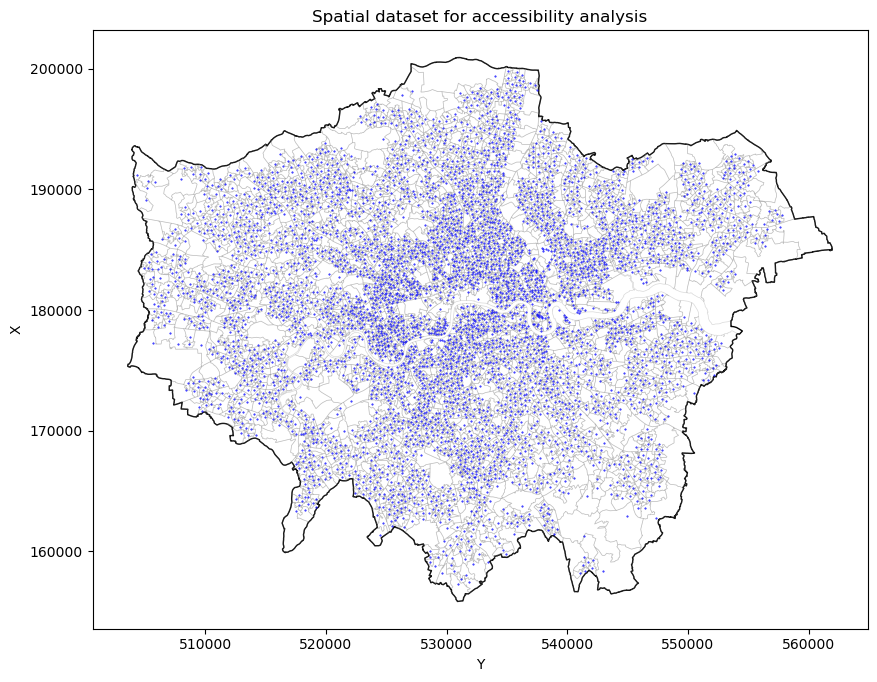

In [4]:
# Build a plot to show the spatial data
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the data for context
gla_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
#borough_boundary.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5,alpha=0.3)
lsoa_boundaries.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5,alpha=0.3)
lsoa_centroids.plot(ax=ax, color='blue', markersize=0.2)

# Add labels, title, or grid
ax.set_title('Spatial dataset for accessibility analysis')
ax.set_xlabel('Y')
ax.set_ylabel('X')

plt.show()

## 2 Calculate active travel accessibility using R5Py
This part contains the following steps:
1. Fetch OpenStreetMap (OSM) data for Greater London using pyrosm; This can alternatively be loaded from a local file. But we will try to fetch the data from the OSM server for a more hassle-free workflow.
2. Create a TransportNetwork object in R5Py using the OSM data; This TransportNetwork object will be used to calculate travel times between any given origins and destinations.
3. The LSOA centroids will be used as both origins and destinations to calculate travel times between all pairs of locations with pre-configured accessibility options.

In [5]:
###### Fetch OSM data using pyrosm ######
# from pyrosm import get_data, OSM
fp = get_data("London")
osm = OSM(fp)

Below we will create a TransportNetwork object in R5Py using the OSM data. R5Py is a Python wrapper for the R5 routing engine, which is a powerful tool for multimodal routing and accessibility analysis. 

In this example, we will only consider walking as the mode of transport, but it can be extended to include other modes such as cycling, driving, or public transport.

In [6]:
###### Create a TransportNetwork object in R5Py using the OSM data ######
transport_network = TransportNetwork(
   osm_pbf=fp,
    #'r5/greater-london-latest.osm.pbf',   # Or directly load the OSM file from local file
   gtfs=[]
    #'r5/improved-gtfs-london-dft.zip'  # Here we use a GTFS feed to calculate public transport travel times, but it will not be used in this example because we only will only be considering active travel modes
)

In [7]:
# Create the origins and destinations GeoDataFrame for calculating the travel time matrix
origins_destinations = gpd.GeoDataFrame(
    {'id': lsoa_centroids['LSOA21CD'], 'geometry': lsoa_centroids['geometry']}, 
    crs=lsoa_centroids.crs)

# Since both origins and destinations are identical, clone the dataframe
origins = origins_destinations.copy()
destinations = origins_destinations.copy()

In [8]:
# Create a TravelTimeMatrixComputer object using R5Py to calculate travel times; Here we only consider walking under the theme of 15-Minute City
# This is a key step as it will determine the travel times between all pairs of origins and destinations in the network
travel_time_computer = TravelTimeMatrixComputer(
    transport_network=transport_network,
    origins=origins, 
    destinations=destinations, 
    #snap_to_network=True,
    
    # Below are some of the travel options that can be tweaked as needed
    transport_modes=['WALK'], # Modes of transport to consider, e.g., 'WALK', 'BICYCLE', 'CAR', 'TRANSIT'
    # speed_walking=3.6,
    max_time=timedelta(minutes=60)
                                                )

# For more information on the available options, please refer to the R5Py documentation: https://r5py.readthedocs.io/en/latest/

In [9]:
# Compute travel times between all origins and destinations; This may take a while but is considerably faster than using API etc.
od_matrix = travel_time_computer.compute_travel_times()
# print(od_matrix.head())

In [10]:
# We have now calculated the travel times between all pairs of origins and destinations, but it could contain NaN values, and it is formulated as table instead of connected networks. Following steps will be taken to address these issues.

# Build an OD matrix with generated time matrix
od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='from_id', right_on='id', suffixes=('', '_from'))
od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='to_id', right_on='id', suffixes=('_from', '_to'))

# Filter rows where travel_time is not NaN
valid_od_matrix = od_matrix[~od_matrix['travel_time'].isna()].copy()

# Create LineStrings from the valid rows
valid_od_matrix['geometry'] = valid_od_matrix.apply(lambda row: LineString([row['geometry_from'], row['geometry_to']]), axis=1)

# Convert to GeoDataFrame
time_matrix = gpd.GeoDataFrame(valid_od_matrix, geometry='geometry')

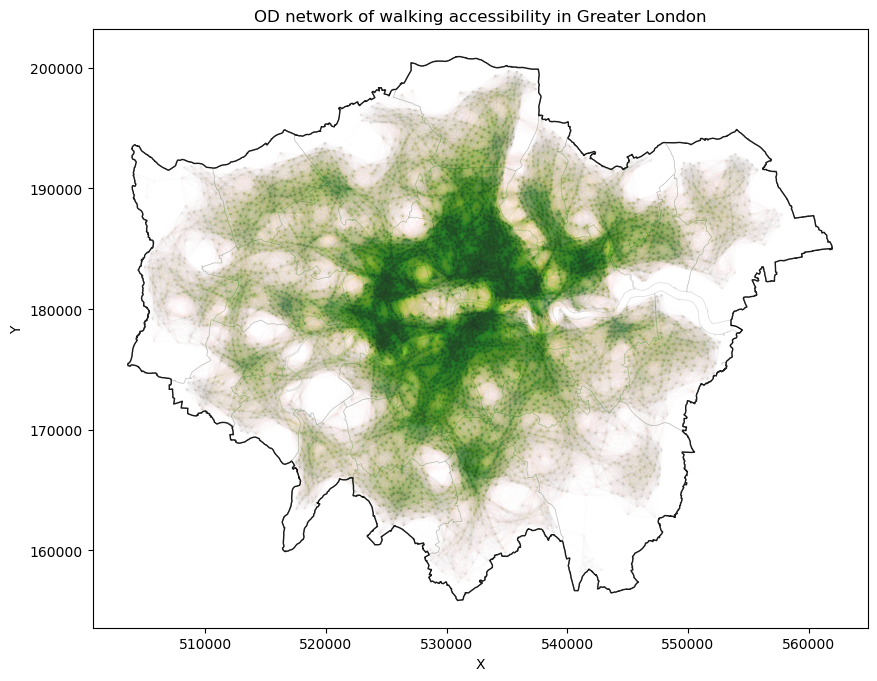

In [11]:
# Build a plot to show the travel times pairs
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the GLA boundary for context
gla_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
borough_boundary.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5,alpha=0.3)

# Plot the OD lines on the same axes
time_matrix.plot(ax=ax, column = "travel_time", scheme='natural_breaks', alpha=0.005)

# Optional: Add labels, title, or grid
ax.set_title('OD network of walking accessibility in Greater London')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [12]:
# Save the time matrix to a CSV file for future reference
# time_matrix.to_csv('time_matrix.csv')

## 3 Visualise active travel accessibility
After calculating the travel times between all pairs of origins and destinations, it is presented in a very complex network. To better understand the accessibility for some area in the city, we can visualize the travel times with LSOA boundarys. 

The following code provide an option by categorizing the travel times into intervals and plotting them on a map.

<Axes: >

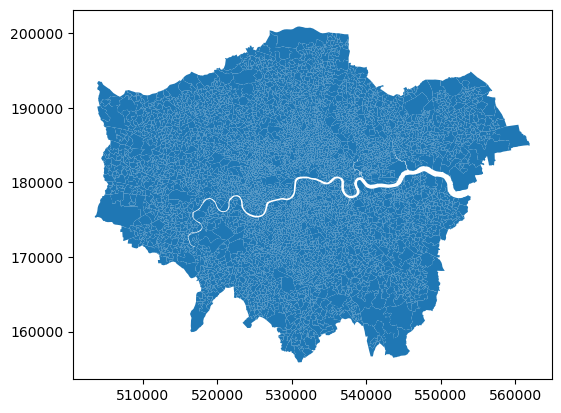

In [13]:
lsoa_boundaries.plot()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_97143/1494635065.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


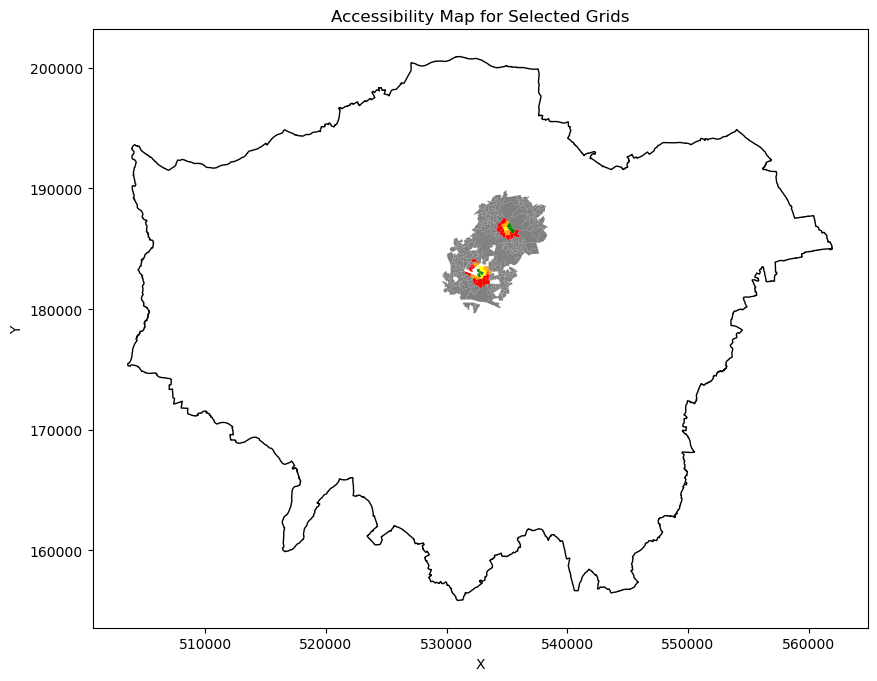

In [14]:
# Plot the travel time matrix for multiple specific origin

# List of selected grid IDs to analyze
selected_ids = ['E01033709', 'E01033710']  # Replace these with your grid IDs

# Define time bins and labels for categorization
time_bins = [0, 5, 10, 15, 20, float('inf')]  # time intervals
time_labels = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '>20 min']
colors = ['green', 'yellow', 'orange', 'red', 'grey']

# Prepare the plot
fig, ax = plt.subplots(figsize=(10,8))

# Add GLA boundary for context
gla_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Process each grid ID and plot on the same map
for grid_id in selected_ids:
    # Filter time matrix for the current grid ID
    filtered_time_matrix = time_matrix[time_matrix['from_id'] == grid_id].drop(columns=['geometry'])

    # Merge with centroids to get spatial data
    access_map = pd.merge(filtered_time_matrix, lsoa_boundaries, how='left', left_on='to_id', right_on='LSOA11CD')
    access_map = gpd.GeoDataFrame(access_map, geometry='geometry', crs=origins_destinations.crs)
    access_map['time_category'] = pd.cut(access_map['travel_time'], bins=time_bins, labels=time_labels, include_lowest=True)

    # Plot each category
    for category, color in zip(time_labels, colors):
        data = access_map[access_map['time_category'] == category]
        data.plot(ax=ax,color=color, label=f"{grid_id} - {category}",markersize=0.5)

# Formatting and legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels

# ax.legend(by_label.values(), by_label.keys(), title='Travel Time')
ax.set_title('Accessibility Map for Selected Grids')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

## This is only a very simple visualisation as if the two grids as closer to each other, the accessibility plots are overlaid on top of each other. It will be solved in the next step.

It can be observed that although the accessibility normally forms an isochrone around the origin, but not all areas are connected within the same time threshold. For transportation planning, it is important to identify the clusters of areas that are not well-connected within a certain travel time threshold. This can help to identify some areas that could benefit from improved active travel infrastructure or connections. 

## 4 Percolation analysis on active travel accessibility
This section will apply percolation clustering analysis to identify the connectivity of active travel networks previously computed based on travel time thresholds. 

Percolation studies how a piece of information spreads in space, reaching a critical point at which a giant cluster appears. In its most general form, the process is defined in an infinite lattice and for a random occupation probability. Relaxing these constraints, the analysis can be extended to finite systems, where the clusters are the outcome of some thresholding process (Aharony, 2018). 

The percolation process on networks can be depicted as follows:

![Schematic diagram of two types of percolation processes (Li et al., 2021)](@li2021a.png)

a) is percolation on bonds (edges), as the vertices below threshold will be deleted and connected components will be clustered; b) is percolation on sites (vertices), as the vertices below threshold will be deleted and connected components will be clustered.


Some examples of percolation in urban contexts include the spread of diseases, the propagation of information, or the connectivity of transportation networks. It can be used to identify vulnerable areas, critical connections, or the most connected regions in a network (Li et al., 2021).

The percolation process can be integrated with a clustering algorithm similar to City Clustering Algorithm (Rozenfeld et al., 2008), which identifies the connected areas as a cluster within a certain threshold. But instead of single threshold, the clustering process can be applied to multiple thresholds to identify the clusters of areas and critical connections under different scenarios (Arcaute et al., 2016).  

In the context of active travel accessibility, it can be used to identify the clusters of areas that are connected within a certain travel time threshold. The percolation threshold is the point at which the network transitions from a collection of isolated clusters to a single connected cluster. This method can help to identify the most accessible areas and the connections between them. 

In [15]:
def percolation_clustering(connections_gdf, time_threshold):
    """
    Apply percolation clustering on the connections GeoDataFrame.
    
    Parameters:
    connections_gdf (GeoDataFrame): GeoDataFrame containing lines representing the connections.
    trip_count_threshold (int): Threshold value for trip_count to filter connections.
    
    Returns:
    GeoDataFrame: Filtered and clustered connections GeoDataFrame with cluster IDs.
    """
    # Step 1: Filter connections based on the trip_count threshold
    filtered_connections = connections_gdf[connections_gdf['travel_time'] <= time_threshold].copy()

    # Step 2: Create a graph from the filtered connections
    G = nx.Graph()
    for idx, row in filtered_connections.iterrows():
        start_point = row.geometry.coords[0]
        end_point = row.geometry.coords[1]
        G.add_edge(start_point, end_point, trip_count=row['travel_time'])

    # Step 3: Identify clusters from the graph
    clusters = list(nx.connected_components(G))
    clusters_sorted = sorted(clusters, key=len, reverse=True)

    # Step 4: Assign cluster IDs to the connections
    cluster_map = {}
    for cluster_id, cluster in enumerate(clusters_sorted):
        for node in cluster:
            cluster_map[node] = cluster_id

    filtered_connections.loc[:, 'cluster_id'] = filtered_connections.apply(
        lambda row: cluster_map[row.geometry.coords[0]], axis=1)

    return filtered_connections

In [16]:
def plot_clusters(clustered_gdf, gla_boundary, borough_boundary, time_threshold):
    """
    Plot the results of percolation clustering for a specific time threshold.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    borough_boundary.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5, alpha=0.7)
    gla_boundary.boundary.plot(ax=ax, edgecolor='black')

    # Plot all connections for context
    cgdf = gpd.GeoDataFrame(clustered_gdf, geometry='geometry', crs=origins_destinations.crs)
    cgdf.plot(ax=ax, color='lightgrey', linewidth=0.6, alpha=0.5)

    # Plot the top 15 clusters with different colors
    top_clusters = clustered_gdf['cluster_id'].value_counts().nlargest(15).index
    top_clustered_gdf = clustered_gdf[clustered_gdf['cluster_id'].isin(top_clusters)]
    top_clustered_gdf = gpd.GeoDataFrame(top_clustered_gdf, geometry='geometry', crs=origins_destinations.crs)
    top_clustered_gdf.plot(ax=ax, column='cluster_id', linewidth=0.6,alpha=0.5, legend=False, cmap='hsv')

    plt.title(f'{time_threshold} min of Walking Accessibility Percolation Clustering in Greater London')
    plt.axis('off')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

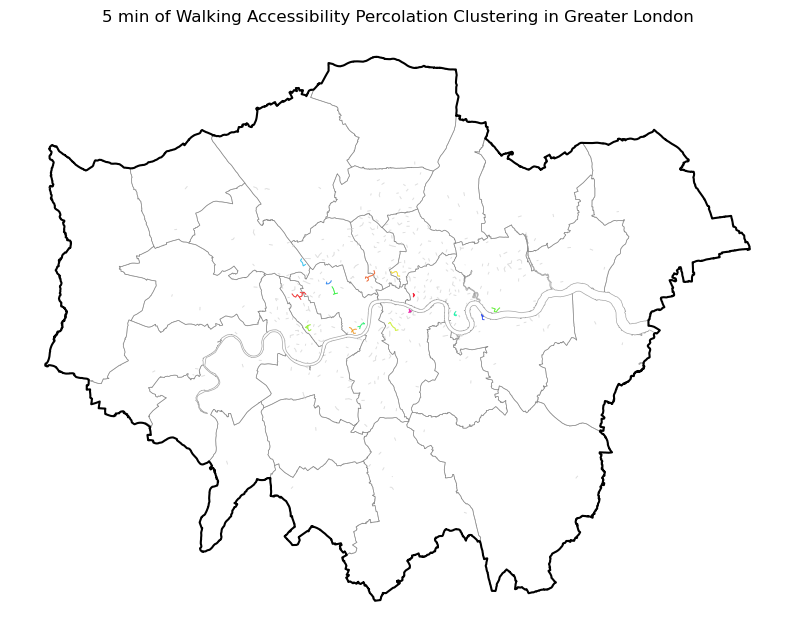

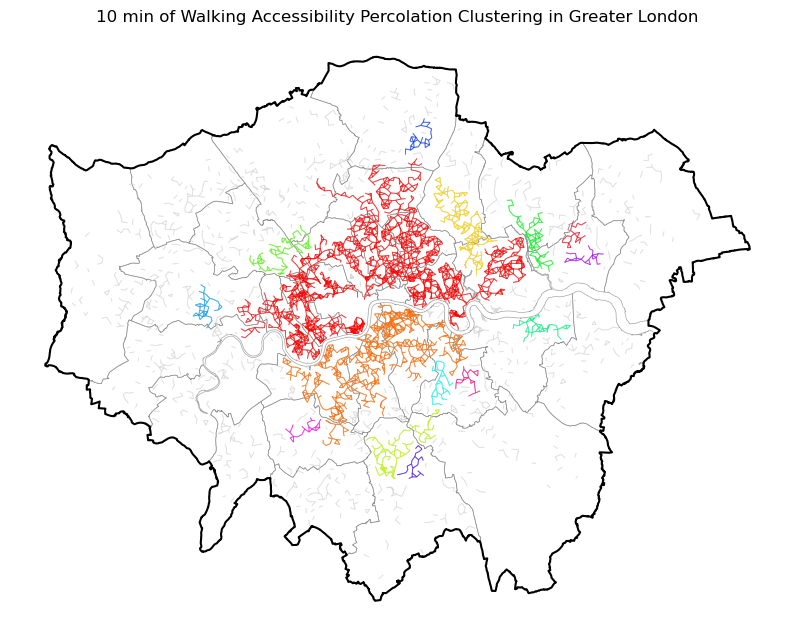

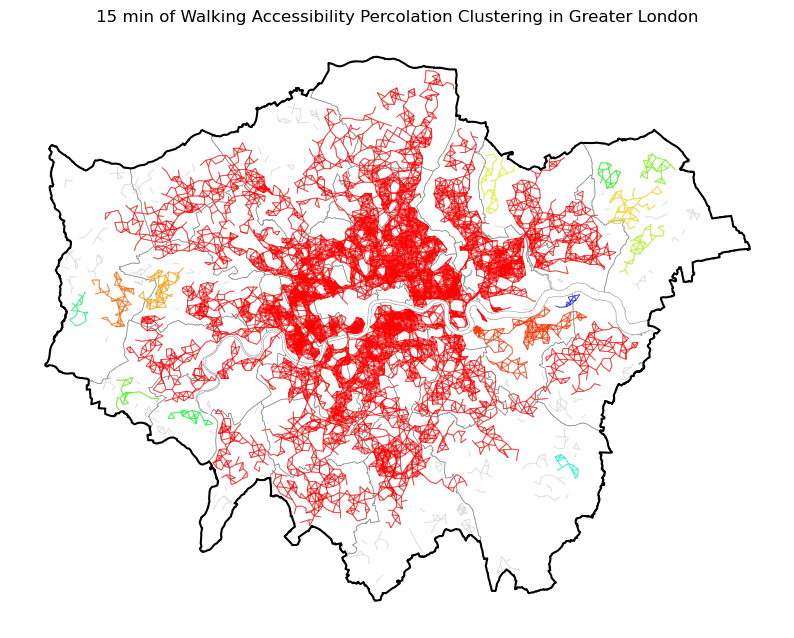

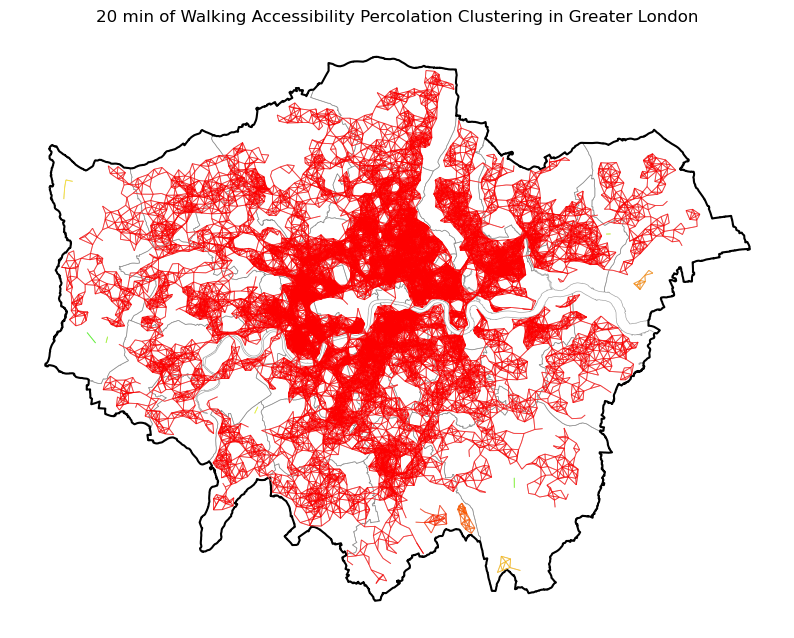

In [17]:
for time_threshold in [5, 10, 15, 20]:
    clustered_gdf = percolation_clustering(valid_od_matrix, time_threshold)
    plot_clusters(clustered_gdf, gla_boundary, borough_boundary, time_threshold)

In the above plots, all the clusters filtered in the percolation process are shown in light grey, while the top 15 clusters are highlighted with different colors. The percolation clustering method helped to identify the most connected areas within a certain travel time threshold. 
Note following things:
1. **Where are the connected areas within every time threshold? How would you interpret the cluster?**
2. **How clusters changes in the different time thresholds? And where are the significant edge in helping connecting the previsouly seperated clusters?**
3. **What are the implications of the percolation results w.r.t. active travel planning/15-minute city  in London?**

Congratulations! You have successfully completed the tutorial on active travel accessibility modelling and connectivity percolation in Greater London. You have learned how to:
1. Calculate active travel accessibility using R5Py;
2. Perform percolation clustering analysis to identify the connectivity of active travel networks based on travel time thresholds.

Hope you find it useful! In the next section, we will try/show some extra things. 

## Extra
For this section, we will try to show two extra things:
1. What would happen if we change the unit of analysis from administrative level to a grid level, which would (supposedly) provide more applicability of the analysis on cities of different contexts.
2. What can the centrality of clusters be calculated to reveal more information about the accessibility connectivity in the network? 

### E.1. Grid-level analysis

[H3](https://h3geo.org/) is a hierarchical grid system that can be used to divide the world into hexagons of various sizes. It is a powerful tool for spatial analysis and can be used to represent spatial data at different levels of granularity. 

In this example, we will use H3 to divide Greater London into hexagons and calculate travel times between all pairs of hexagons.

You don't need to run the process in this tutorial, as it is time-consuming and requires a lot of computational power. But you can see the code and output to understand the process.

In [74]:
# Import necessary libraries
import h3
import h3pandas

In [110]:
# Setting level for H3 grid
h3_level = 9 # Equivalent to hexagons with ~0.2 km side length

# Generate hexagons within the boundary use h3pandas
gla_copy = gla_boundary.copy()
gla_hexagons = gla_copy.to_crs('EPSG:4326').h3.polyfill_resample(h3_level)

# Drop the generated index column and reset the index
gla_hexagons.drop(columns=['index'], inplace=True)
gla_hexagons = gla_hexagons.reset_index(drop=False)

print('Number of hexagons:', len(gla_hexagons))
# gla_hexagons.to_file('gla_hexagons.geojson', driver='GeoJSON')

Number of hexagons: 16890


In [111]:
# Calculate centroids only once and use it for both origins and destinations, same as before but use the centroids of hexagons
centroids = gla_hexagons.centroid

# Create a single GeoDataFrame and set the CRS in the same step
origins_destinations = gpd.GeoDataFrame({'id': gla_hexagons['h3_polyfill'], 'geometry': centroids})
origins_destinations.to_crs('EPSG:27700', inplace=True)

# Since both origins and destinations are identical, clone the dataframe
origins = origins_destinations.copy()
destinations = origins_destinations.copy()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_79323/2421381508.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gla_hexagons.centroid


In [112]:
# Create a TravelTimeMatrixComputer object using R5Py to calculate travel times
travel_time_computer = TravelTimeMatrixComputer(transport_network,
                                                origins=origins, destinations=destinations,
                                                #snap_to_network=True,
                                                transport_modes=['WALK'],
                                                max_time=timedelta(minutes=60)
                                                )

In [114]:
# Compute travel times between all origins and destinations
# od_matrix = travel_time_computer.compute_travel_times()

#### This section is commented out as it is time-consuming and requires a lot of computational power, but you can run it on your local machine if needed.

In [115]:
# Build an OD matrix with generated time matrix
od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='from_id', right_on='id', suffixes=('', '_from'))
od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='to_id', right_on='id', suffixes=('_from', '_to'))

# Filter rows where travel_time is not NaN
valid_od_matrix = od_matrix[~od_matrix['travel_time'].isna()].copy()

# Create LineStrings from the valid rows
valid_od_matrix['geometry'] = valid_od_matrix.apply(lambda row: LineString([row['geometry_from'], row['geometry_to']]), axis=1)

# Convert to GeoDataFrame
time_matrix = gpd.GeoDataFrame(valid_od_matrix, geometry='geometry')

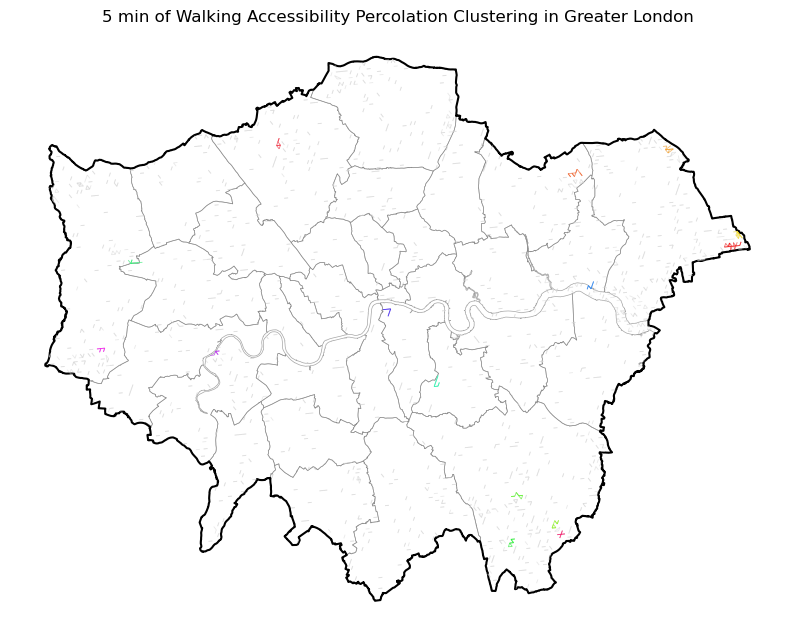

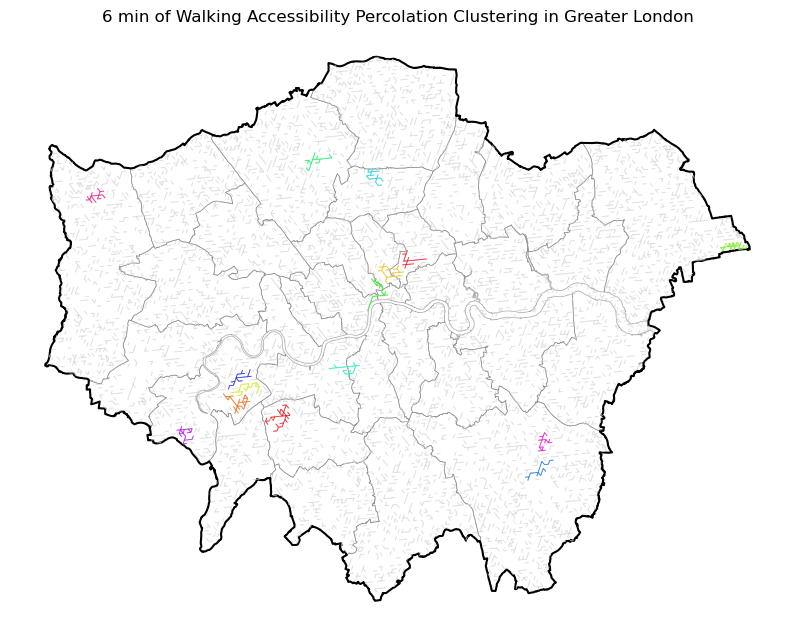

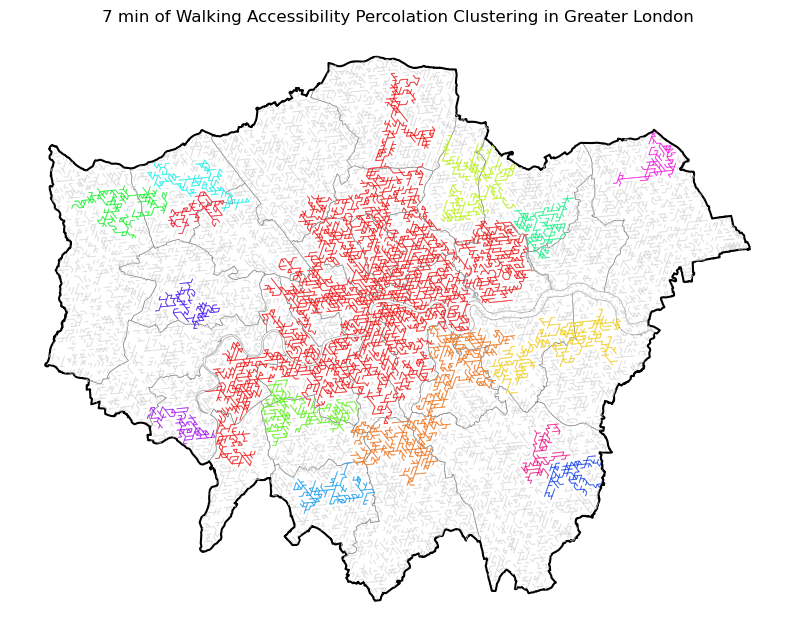

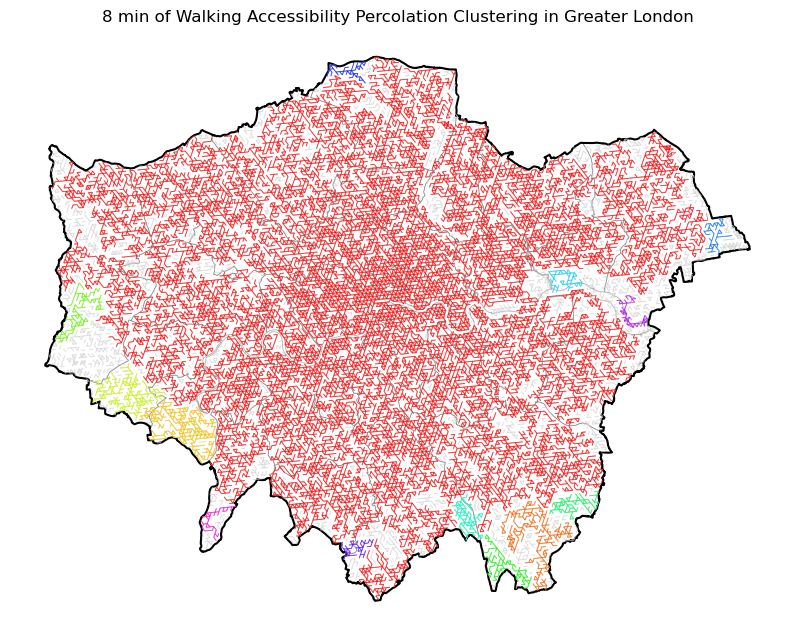

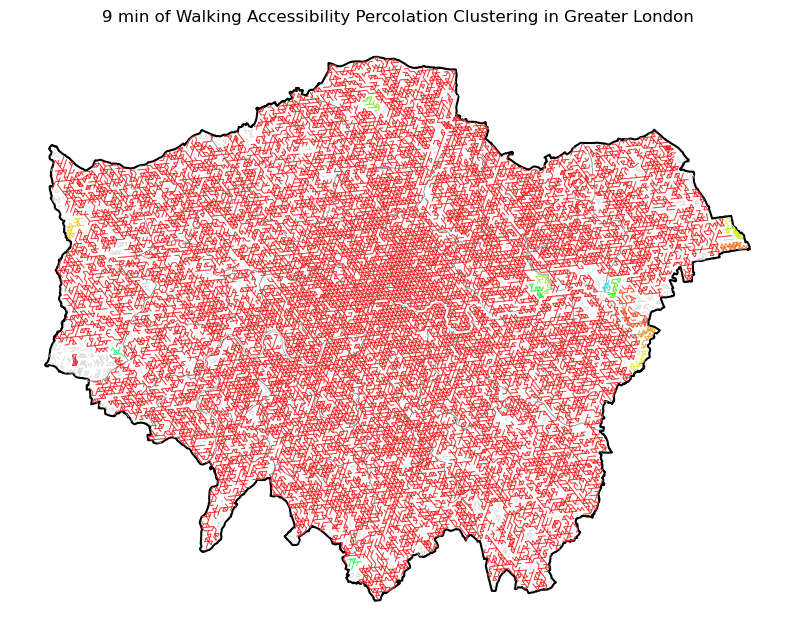

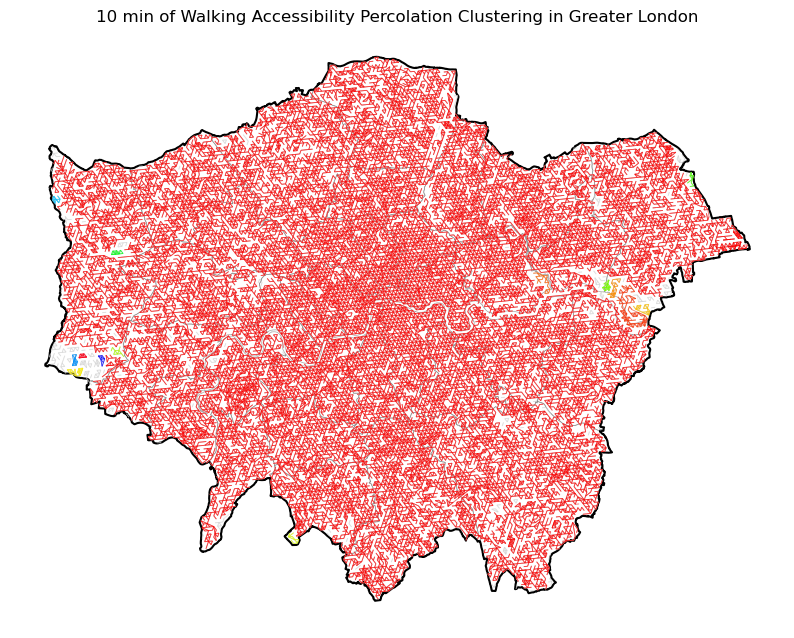

In [117]:
for time_threshold in [5,6,7,8,9,10]:
    clustered_gdf = percolation_clustering(time_matrix, time_threshold)
    plot_clusters(clustered_gdf, gla_boundary, borough_boundary, time_threshold)

The percolation clustering results on grid level provide a more detailed view of the connectivity of active travel accessibility in Greater London. However, it is important to note that the hexagonal grids are homogeneous and may not accurately represent the actual travel patterns in the city, e.g., the uneven distribution of population or land use in the cities. An existing travel pair does not mean that there is actual travel need between the two points (Therefore in this part, some of the links are possibly does not represent real world scenarios).

Therefore, for more accurate analysis, it is recommended to use origins and destinations that actually represent urban spatial structure, or that a homogenous tessellation should be supplemented with additional data to account for the spatial heterogeneity in the city (population density, employment, amenities, etc.).

### E.2 Centrality analysis of clusters

## References
Aharony, A. (2018). Introduction To Percolation Theory: Second Edition. Taylor & Francis. https://doi.org/10.1201/9781315274386

Arcaute, E., Molinero, C., Hatna, E., Murcio, R., Vargas-Ruiz, C., Masucci, A. P., & Batty, M. (2016). Cities and regions in Britain through hierarchical percolation. Royal Society Open Science, 3(4), 150691. https://doi.org/10.1098/rsos.150691

H3. (2023). H3 Documentation. https://h3geo.org/

Li, M., Liu, R.-R., Lü, L., Hu, M.-B., Xu, S., & Zhang, Y.-C. (2021). Percolation on complex networks: Theory and application. Physics Reports, 907, 1–68. https://doi.org/10.1016/j.physrep.2020.12.003

ONS. (2021). Area types. Office for National Statistics. https://www.ons.gov.uk/census/census2021dictionary/areatypedefinitions

R5Py. (2023). R5Py Documentation. https://r5py.readthedocs.io/en/latest/

Rozenfeld, H. D., Rybski, D., Andrade, J. S., Batty, M., Stanley, H. E., & Makse, H. A. (2008). Laws of population growth. Proceedings of the National Academy of Sciences, 105(48), 18702–18707. https://doi.org/10.1073/pnas.0807435105

Schlosser, I., Maureira, V. M., Milton, R., Arcaute, E., & Batty, M. (2023). Active-travel modelling: A methodological approach to networks for walking and cycling commuting analysis (arXiv:2309.02112). arXiv. https://doi.org/10.48550/arXiv.2309.02112

